In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")

from src.training_utils.training import get_model_instance_segmentation
from src.training_utils.dataset import *
from src.constants import *
import PIL

In [48]:
import cv2
import torch
import numpy as np
import pandas as pd
from ast import literal_eval
from torchvision.ops import box_iou

In [4]:
le_dict = get_encoder_dict(CLASSES_CSV)
num_classes = len(le_dict)+1 
num_classes

6

## 1. Primero con los modelos de Pytorch

In [5]:
PATH_TO_LOAD_MODEL_FASTER = f"/home/nacho/TFI-Cazcarra/data/models/model_best_cardinalidades_fasterrcnn.pt"
PATH_TO_LOAD_MODEL_RETINANET = f"/home/nacho/TFI-Cazcarra/data/models/model_best_cardinalidades_fasterrcnn.pt"

In [6]:
model = torch.jit.load(PATH_TO_LOAD_MODEL_FASTER)
model.to("cpu")
model.eval()

RecursiveScriptModule(
  original_name=FasterRCNN
  (transform): RecursiveScriptModule(original_name=GeneralizedRCNNTransform)
  (backbone): RecursiveScriptModule(
    original_name=BackboneWithFPN
    (body): RecursiveScriptModule(
      original_name=IntermediateLayerGetter
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=FrozenBatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
      (layer1): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Bottleneck
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(original_name=FrozenBatchNorm2d)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (bn2): RecursiveScriptModule(original_name=FrozenBatchNorm2d)
          (conv3): RecursiveScriptModule(original_name=Conv2d)


### 1.1 Cargamos lo necesario del bbox slicer

In [7]:
import image_bbox_slicer as ibs
from image_bbox_slicer.helpers import * 
from image_bbox_slicer.slicer import Points

In [8]:
im_src = f'{PATH}/data/imagenes_diagramas'
an_src = f'{PATH}/data/xml_diagramas'
im_dst = f'{PATH}/data/tiles/image_slices'
an_dst = f'{PATH}/data/tiles/xml_slices'

In [9]:
slicer = ibs.Slicer()
# slicer.config_dirs(img_src=im_src, ann_src=an_src, 
#                    img_dst=im_dst, ann_dst=an_dst)

slicer.keep_partial_labels = True
slicer.save_before_after_map = True

In [10]:
def calc_columns_rows(n):
    """Calculates the number of columns and rows required to divide an image
    into equal parts.
    Parameters
    ----------
    n : int
        The number of equals parts an image should be split into.
    Returns
    ----------
    tuple
        Size required to divide an image into in pixels, as a 2-tuple: (columns, rows)..
    """
    num_columns = int(ceil(sqrt(n)))
    num_rows = int(ceil(n / float(num_columns)))

    return (num_columns, num_rows)

In [11]:
def slice_images(file, slicer, tile_size, number_tiles):
    im = Image.open(file)
    
    if number_tiles > 0:
        n_cols, n_rows = calc_columns_rows(number_tiles)
        tile_w, tile_h = int(
            floor(im.size[0] / n_cols)), int(floor(im.size[1] / n_rows))
        tile_size = (tile_w, tile_h)

    tiles = __get_tiles(im.size, tile_size)
    return tiles

In [12]:
def __get_tiles(img_size, tile_size):
    """Generates a list coordinates of all the tiles after validating the values.
    Private Method.
    Parameters
    ----------
    img_size : tuple
        Size of the original image in pixels, as a 2-tuple: (width, height).
    tile_size : tuple
        Size of each tile in pixels, as a 2-tuple: (width, height).
    tile_overlap: float
        Percentage of tile overlap between two consecutive strides.
    Returns
    ----------
    list
        A list of tuples.
        Each holding coordinates of possible tiles
        in the format - `(xmin, ymin, xmax, ymax)`
    """
    validate_tile_size(tile_size, img_size)
    tiles = []
    img_w, img_h = img_size
    tile_w, tile_h = tile_size
    
    tile_overlap = 0.0
    stride_w = int((1 - tile_overlap) * tile_w)
    stride_h = int((1 - tile_overlap) * tile_h)
    
    tile_overlap = 0.6
    tmp_stride_w = int((1 - tile_overlap) * tile_w)
    tmp_stride_h = int((1 - tile_overlap) * tile_h)
        
    for y in range(0, img_h-tile_h+1, stride_h):
        
        reached_max_h = (y + tile_h + stride_h >= img_h-tile_h)
        just_started_h = (y == 0)

        if(just_started_h):
            y = 0
            y2 = y + tile_h + tmp_stride_h
        elif(reached_max_h):
            y -= tmp_stride_h
            y2 = y + tile_h + tmp_stride_h
        else:
            y += tmp_stride_h//2
            y2 = y + tile_h + tmp_stride_h//2

        for x in range(0, img_w-tile_w+1, stride_w):            
            reached_max_w = (x + tile_w + stride_w >= img_w-tile_w)

            just_started_w = (x == 0)

            if(just_started_w):
                x = 0
                x2 = x + tile_w + tmp_stride_w
            elif(reached_max_w):
                x -= tmp_stride_w
                x2 = x + tile_w + tmp_stride_w
            else:
                x += tmp_stride_w//2
                x2 = x + tile_w + tmp_stride_w//2
            
            tiles.append((x, y, x2, y2))                
    return tiles

In [13]:
def validate_tile_size(tile_size, img_size=None):
    """Validates tile size argument provided for slicing.
    Parameters
    ----------
    tile_size : tuple
        Size of each tile in pixels, as a 2-tuple: (width, height).
    img_size : tuple, optional
        Size of original image in pixels, as a 2-tuple: (width, height).
    Returns
    ----------
    None
    Raises
    ----------
    ValueError
        If `tile_size` does not hold exactly `2` values
        If `tile_size` does not comply with `img_size`
    TypeError
        If `tile_size` or `img_size` are not of type tuple.
    """
    if img_size is None:
        if isinstance(tile_size, tuple):
            if len(tile_size) != 2:
                raise ValueError(
                    'Tile size must be a tuple of size 2 i.e., (w, h). The tuple provided was {}'.format(tile_size))
        else:
            raise TypeError(
                'Tile size must be a tuple. The argument was of type {}'.format(type(tile_size)))
    else:
        if isinstance(img_size, tuple):
            if (sum(tile_size) >= sum(img_size)) or (tile_size[0] > img_size[0]) or (tile_size[1] > img_size[1]):
                raise ValueError('Tile size cannot exceed image size. Tile size was {} while image size was {}'.format(
                    tile_size, img_size))
        else:
            raise TypeError(
                'Image size must be a tuple. The argument was of type {}'.format(type(img_size)))

In [68]:
def draw_bbox(img, xmin, ymin, xmax, ymax): 
    return cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), 
                         (255,0,0), 1)


def unify_images(img, boxes_per_tile):
    img = np.array(img)
    first_tile = next(iter(boxes_per_tile.keys()))
    
    for tile, prediction in boxes_per_tile.items():
        coords_to_add = torch.Tensor(list(map(lambda i,j: i-j, literal_eval(tile), literal_eval(first_tile))))
        prediction = prediction[0]

        boxes = torch.add(prediction['boxes'], coords_to_add, alpha=1).detach().numpy().tolist()
        
        for box, score, label in zip(boxes, prediction['scores'], prediction['labels']):
            score = round(score.item(), 3)
            label = label.item()
            if score <= 0.6:
                continue
        
            img = draw_bbox(img, *box)
            
    return img

In [90]:
path_image = "/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-17.png"

tiles_img = slice_images(file=path_image, 
               slicer=slicer, tile_size=None, number_tiles=6)

print(f"Tiles: {tiles_img}")

image = Image.open(path_image)
preds_image = {}

with torch.no_grad():
    for tile in tiles_img:
        print("Predicting tile...")
        cropped = image.crop(tile)
        tensor_tile = T.ToTensor()(cropped)
        predictions = model([tensor_tile])
        preds_image[str(tile)] = predictions[1]

Tiles: [(0, 0, 595, 464), (255, 0, 850, 464), (680, 0, 1275, 464), (0, 200, 595, 664), (255, 200, 850, 664), (680, 200, 1275, 664)]
Predicting tile...
Predicting tile...
Predicting tile...
Predicting tile...
Predicting tile...
Predicting tile...


In [91]:
image = image.convert("RGB")
img_resultado = unify_images(img=image, boxes_per_tile=preds_image)

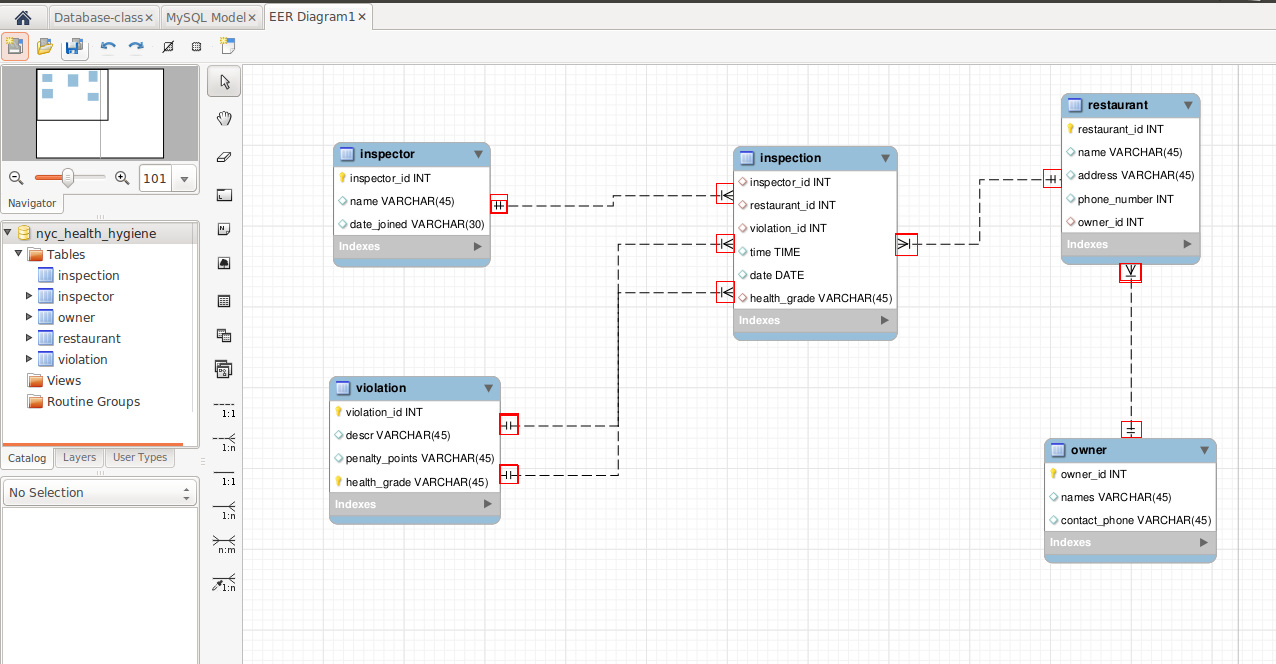

In [92]:
Image.fromarray(img_resultado)